# Asteroid use case notebook

ALeRCE starter notebook for asteroid science.

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

You will need to install psycopg2 and the alerce api

In this notebook you will connect to the ALeRCE database, and download asteroid candidates from the last 10 days

You will plot their spatial distribution using datashader and bokeh

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [2]:
from matplotlib.cm import viridis

Use pyephem https://pypi.org/project/pyephem/

In [3]:
#!pip install pyephem
import ephem

Install psycopg2 https://github.com/psycopg/psycopg2

In [4]:
#!pip install psycopg2-binary
import psycopg2

### Get credentials (in github repository)

In [5]:
import json
credentials_file = "../alercereaduser_v3.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [6]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

The new DB contains the following tables:
    
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS object as reported by ZTF
* `ss_ztf`: closest MPC object as reported by ZTF
* `gaia_ztf`: closet GAIA source as reported by ZTF
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

### Show all the available tables

In [7]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
7         allwise
14    dataquality
13      detection
1         feature
4        gaia_ztf
6         magstat
0   non_detection
2          object
8        pipeline
11    probability
15        ps1_ztf
12      reference
10         ss_ztf
9            step
3        taxonomy
5          xmatch

### For each table, show column names and column types

In [8]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table         column_name          data_type
0         allwise         oid_catalog  character varying
1         allwise                  ra   double precision
2         allwise                 dec   double precision
3         allwise              w1mpro   double precision
4         allwise              w2mpro   double precision
5         allwise              w3mpro   double precision
6         allwise              w4mpro   double precision
7         allwise           w1sigmpro   double precision
8         allwise           w2sigmpro   double precision
9         allwise           w3sigmpro   double precision
10        allwise           w4sigmpro   double precision
11        allwise           j_m_2mass   double precision
12        allwise           h_m_2mass   double precision
13        allwise           k_m_2mass   double precision
14        allwise        j_msig_2mass   double precision
15        allwise        h_msig_2mass   double precision
16        allwise        k_msig_2mass   double precision
0     dataquality                 oid  character varying
1     dataquality              candid             bigint
2     dataquality                 fid            integer
3     dataquality                xpos               real
4     dataquality                ypos               real
5     dataquality              chipsf               real
6     dataquality                 sky               real
7     dataquality                fwhm               real
8     dataquality            classtar               real
9     dataquality          mindtoedge               real
10    dataquality            seeratio               real
11    dataquality              aimage               real
12    dataquality              bimage               real
13    dataquality           aimagerat               real
14    dataquality           bimagerat               real
15    dataquality                nneg            integer
16    dataquality                nbad            integer
17    dataquality              sumrat               real
18    dataquality               scorr   double precision
19    dataquality              dsnrms               real
20    dataquality              ssnrms               real
21    dataquality            magzpsci               real
22    dataquality         magzpsciunc               real
23    dataquality         magzpscirms               real
24    dataquality            nmatches            integer
25    dataquality            clrcoeff               real
26    dataquality            clrcounc               real
27    dataquality            zpclrcov               real
28    dataquality               zpmed               real
29    dataquality              clrmed               real
30    dataquality              clrrms               real
31    dataquality             exptime               real
0       detection                 oid  character varying
1       detection              candid             bigint
2       detection                 mjd   double precision
3       detection                 fid            integer
4       detection                 pid             bigint
5       detection          diffmaglim               real
6       detection           isdiffpos           smallint
7       detection                 nid            integer
8       detection                  ra   double precision
9       detection                 dec   double precision
10      detection              magpsf               real
11      detection            sigmapsf               real
12      detection               magap               real
13      detection            sigmagap               real
14      detection              distnr               real
15      detection                  rb               real
16      detection           rbversion  character varying
17      detection                 drb               real
18      detection          drbversion  character varying
19      detection            magapbig               real
20      detection     

### Query objects which appeared between Jan 1st 2020 and Feb 1st 2020, which have at most one detection, and which are classified as asteroids by the early classifier with a probability greater than 0.7

In [49]:
mjd_first = Time("2020-01-01T00:00:00", scale='utc').mjd
mjd_last = Time("2020-02-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='Asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

(112599, 4)


meanra    meandec      firstmjd  ndet
oid                                                   
ZTF20aaejdix  20.857953  44.947847  58855.195637     1
ZTF20aaaclyt  34.036909  42.920540  58849.144005     1
ZTF20aafdqsd  31.634515  41.294746  58862.137338     1
ZTF20aaaeljl  37.554472  41.403419  58849.187072     1
ZTF20aaeauow  34.894123  39.536790  58854.160347     1

# Check whether these objects are reported as known asteroids

In [94]:
mjd_first = Time("2020-01-01T00:00:00", scale='utc').mjd
mjd_last = Time("2020-01-02T00:00:00", scale='utc').mjd

query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

(112599, 5)


oid               candid  ssdistnr  ssmagnr ssnamenr
0  ZTF17aacsnej  1113270013415015015       0.0     17.7    31651
1  ZTF18aabqgan  1123482312215015016       0.0     19.6   209007
2  ZTF18aabtebd  1122337880615015003       0.0     18.7    61128
3  ZTF18abtgcmt  1105089831815015002       1.0     17.0     3629
4  ZTF18abtgodz  1121144804215015000       1.0     18.6    15335

# Plot distribution of separations for those objects with a xmatch in MPC

Fraction of object with a match in MPC: 0.99


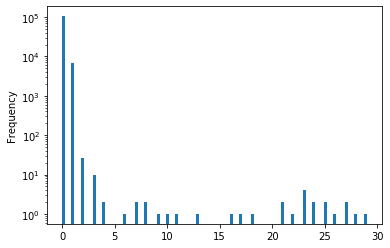

In [111]:
mask = (ss.ssdistnr>=0)
print("Fraction of object with a match in MPC: %.2f" % (mask.sum() / ast.shape[0]))
ss.loc[mask].ssdistnr.plot.hist(bins=100, log=True)

# Plot distribution in the sky using datashader

In [96]:
import datashader as ds
import datashader.transfer_functions as tf
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

In [97]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ast, 'meanra', 'meandec', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# Move to ecliptic coordinates

In [98]:
ecl = ast.apply(lambda row: ephem.Ecliptic(ephem.Equatorial('%s' % (row.meanra / 15.), '%s' % row.meandec, epoch=ephem.J2000)), axis=1)

In [99]:
ast["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
ast["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))

In [100]:
ast["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
ast["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))

In [101]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(ast, 'ecl_long', 'ecl_lat', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Note that most selected objects are around the ecliptic. Also note that you can see individual tracks!

# Plot histogram of ecliptic latitudes

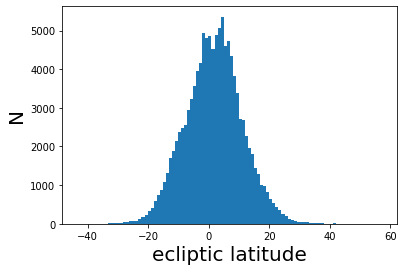

In [102]:
fig, ax = plt.subplots()
ax.hist(ast.ecl_lat, bins=100);
ax.set_xlabel("ecliptic latitude", fontsize=20)
ax.set_ylabel("N", fontsize=20)
plt.savefig("asteroid_ecl_lat.png")

# Show the object with the largest number of detections

In [112]:
ndet = ss.loc[mask].groupby("ssnamenr").apply(lambda df: df.shape[0])

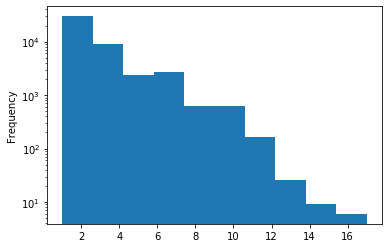

In [115]:
ndet.plot.hist(log=True)

In [117]:
bestast = ndet.idxmax()

Text(0, 0.5, 'DEC')

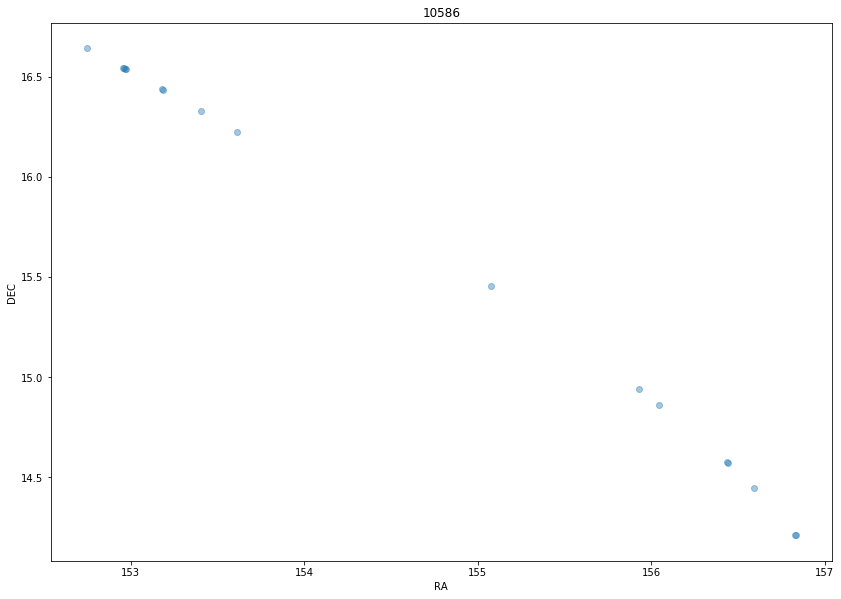

In [126]:
fig, ax = plt.subplots(figsize=(14, 14/np.sqrt(2)))
oids = ss.loc[ss.ssnamenr == bestast].oid
maskbest = ast.index.isin(oids)
ax.scatter(ast.loc[maskbest].meanra, ast.loc[maskbest].meandec, alpha=0.4)
ax.set_title(bestast)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")